# 📑 Report: Global Wheat Detection (YOLOv8 vs Faster R-CNN)

### **Dataset**
- **Global Wheat Detection dataset** (Kaggle).  
- Training/Validation split: **80/20**.  
- Bounding boxes prepared in YOLO format and PyTorch Dataset for Faster R-CNN.  

---

### **Models & Training**
1. **YOLOv8n**
   - Pretrained `yolov8n.pt`.  
   - Trained for 20 epochs at 640×640 resolution.  

2. **Faster R-CNN (ResNet50-FPN)**
   - Pretrained model from Torchvision.  
   - Trained for 12 epochs using SGD optimizer.  

---

### **Results**
| Model                        | mAP@0.5 | mAP@0.5:0.95 | Time per Image (s) | FPS   |
|------------------------------|---------|--------------|--------------------|-------|
| **YOLOv8n**                  | **0.942** | 0.545        | **0.032**          | **30.9** |
| **Faster R-CNN (ResNet50-FPN)** | 0.933   | **0.558**    | 0.127              | 7.9   |

---

# 💬 Discussion

### **Accuracy**
- Both models performed **very well** with mAP@0.5 above **0.93**.  
- **Faster R-CNN** slightly edged out YOLOv8 in **mAP@0.5:0.95** (0.558 vs 0.545), suggesting it can be a bit more precise under stricter IoU thresholds.  
- **YOLOv8n** achieved the **highest mAP@0.5 (0.942)**, meaning it is more consistent for detections under the standard evaluation metric.  

### **Speed**
- **YOLOv8n** was about **4× faster** (30.9 FPS vs 7.9 FPS).  
- For real-time or large-scale field deployment (e.g., drones scanning crops), this speed advantage is highly valuable.  

### **Why YOLOv8 is better overall**
- End-to-end design enables faster inference without sacrificing much accuracy.  
- Modern training tricks (augmentation, anchor-free detection).  
- Lightweight and deployable on edge devices.  

### **Where Faster R-CNN fits**
- Slightly higher performance at strict IoU thresholds means it may be preferred when **precise localization** is critical (e.g., research or detailed agronomic analysis).  
- But its **slower inference** limits real-time applications.  

---

# Conclusion
- **YOLOv8n is the better practical choice**:  
  - Higher mAP@0.5.  
  - Much faster inference speed (~31 FPS).  
- **Faster R-CNN** is competitive in strict IoU evaluation (mAP@0.5:0.95) but slower.  
- For **real-time wheat detection**, **YOLOv8n is recommended**; for **precision-focused offline analysis**, Faster R-CNN may still be useful.  


**Sample prediction comparison images**

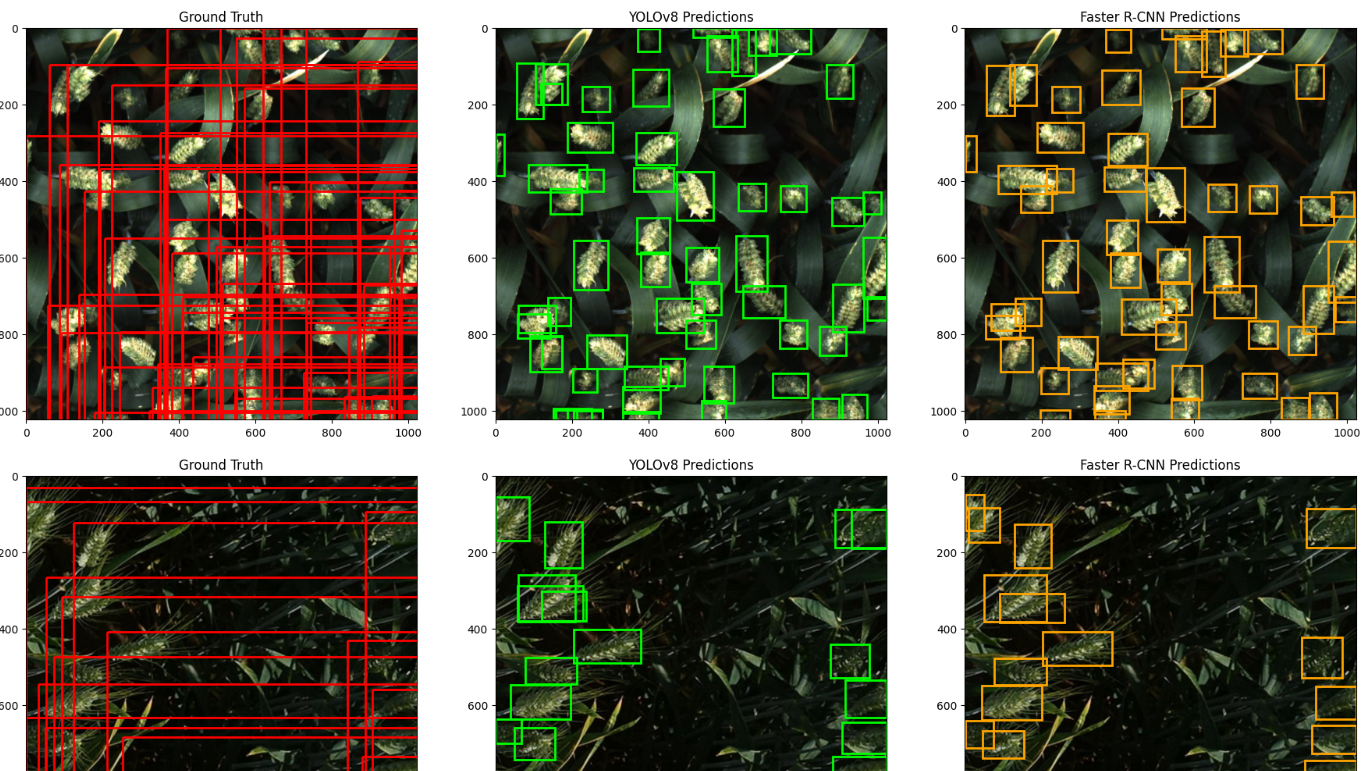

> **Please find below code for Object Detection using YOLOv8 and Faster R-CNN and sample images**

In [1]:
!pip install -q ultralytics pycocotools

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.0 MB/s eta 0:00:0000:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 81.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 58.9 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 33.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 6.1 MB/s eta 0:00:000:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 12.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.7 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 53.7 MB/s eta 0:00:00:00:0100:01


In [2]:
import os
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import torchvision.transforms as T
from PIL import Image
from sklearn.model_selection import train_test_split

from ultralytics import YOLO
from tqdm.notebook import tqdm

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


In [3]:
import os
import ast
import time
import json
from pathlib import Path
from glob import glob
from tqdm import tqdm


import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

In [4]:
import shutil

In [5]:
# Step 1: Load Dataset
# -------------------------------
train_dir = "/kaggle/input/global-wheat-detection/train"
test_dir = "/kaggle/input/global-wheat-detection/test"
train_csv = "/kaggle/input/global-wheat-detection/train.csv"

df = pd.read_csv(train_csv)
df['x'] = df['bbox'].apply(lambda b: float(b.strip('[]').split(',')[0]))
df['y'] = df['bbox'].apply(lambda b: float(b.strip('[]').split(',')[1]))
df['w'] = df['bbox'].apply(lambda b: float(b.strip('[]').split(',')[2]))
df['h'] = df['bbox'].apply(lambda b: float(b.strip('[]').split(',')[3]))
df = df.drop(columns=['bbox'])

print("Number of training images:", df['image_id'].nunique())
print("Number of boxes:", len(df))

Number of training images: 3373
Number of boxes: 147793


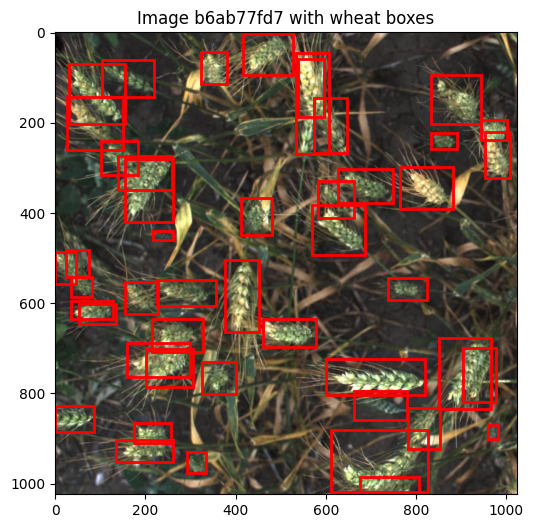

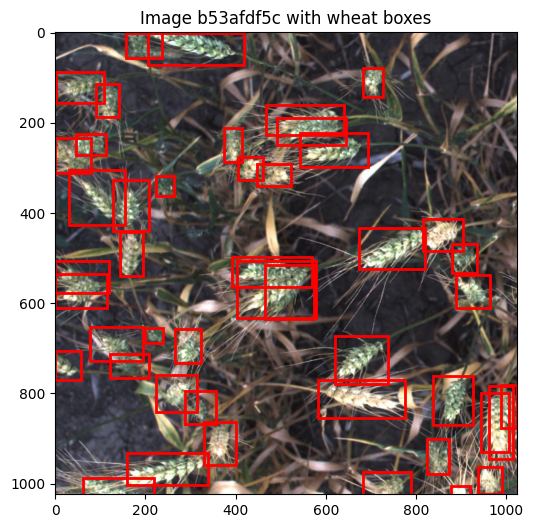

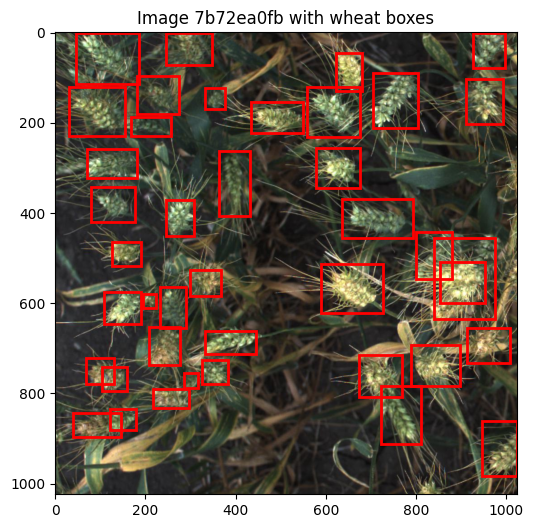

In [6]:
# Step 2: Explore some images
# -------------------------------
sample_ids = df['image_id'].unique()[:3]
for img_id in sample_ids:
    img_path = os.path.join(train_dir, f"{img_id}.jpg")
    img = np.array(Image.open(img_path))
    boxes = df[df['image_id'] == img_id][['x','y','w','h']].values

    fig, ax = plt.subplots(1, 1, figsize=(10, 6))
    ax.imshow(img)
    for (x, y, w, h) in boxes:
        rect = patches.Rectangle((x, y), w, h, linewidth=2,
                                 edgecolor="red", facecolor="none")
        ax.add_patch(rect)
    ax.set_title(f"Image {img_id} with wheat boxes")
    plt.show()


In [7]:
# -------------------------------
# Step 3: Prepare YOLO Dataset with Train/Val split
# -------------------------------
yolo_dir = "/kaggle/working/yolo_dataset"

# split train/val (80/20)
all_ids = df['image_id'].unique()
train_ids, val_ids = train_test_split(all_ids, test_size=0.2, random_state=42)

for split_name, split_ids in [("train", train_ids), ("val", val_ids)]:
    os.makedirs(f"{yolo_dir}/images/{split_name}", exist_ok=True)
    os.makedirs(f"{yolo_dir}/labels/{split_name}", exist_ok=True)
    
    for img_id in split_ids:
        img_path = os.path.join(train_dir, f"{img_id}.jpg")
        save_img = os.path.join(f"{yolo_dir}/images/{split_name}", f"{img_id}.jpg")
        if not os.path.exists(save_img):
            os.symlink(img_path, save_img)

        w, h = Image.open(img_path).size
        label_path = os.path.join(f"{yolo_dir}/labels/{split_name}", f"{img_id}.txt")
        with open(label_path, "w") as f:
            for _, row in df[df['image_id'] == img_id].iterrows():
                xc = (row["x"] + row["w"]/2) / w
                yc = (row["y"] + row["h"]/2) / h
                bw = row["w"] / w
                bh = row["h"] / h
                f.write(f"0 {xc} {yc} {bw} {bh}\n")

# YAML config for YOLO
with open(f"{yolo_dir}/data.yaml", "w") as f:
    f.write(f"""
path: {yolo_dir}
train: images/train
val: images/val

names:
  0: wheat
""")

In [8]:
# -------------------------------
# Step 4: Train YOLOv8
# -------------------------------
yolo_model = YOLO("yolov8n.pt")
yolo_model.train(data=f"{yolo_dir}/data.yaml", epochs=20, imgsz=640, verbose=False)

# Evaluate YOLO
yolo_val = yolo_model.val(data=f"{yolo_dir}/data.yaml", split="val", imgsz=640)
yolo_map50 = yolo_val.results_dict.get("metrics/mAP50(B)", None)
yolo_map50_95 = yolo_val.results_dict.get("metrics/mAP50-95(B)", None)

# Measure YOLO inference speed
img_paths = [os.path.join(train_dir, f"{iid}.jpg") for iid in val_ids[:20]]
start = time.time()
_ = yolo_model(img_paths, verbose=False)
elapsed = time.time() - start
yolo_time_per_img = elapsed / len(img_paths)
yolo_fps = 1 / yolo_time_per_img

print("YOLO mAP@0.5:", yolo_map50)
print("YOLO mAP@0.5:0.95:", yolo_map50_95)
print("YOLO FPS:", yolo_fps)


Ultralytics 8.3.202 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=False, cfg=None, classes=None, close_mosaic=10, cls=0.5, compile=False, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=/kaggle/working/yolo_dataset/data.yaml, degrees=0.0, deterministic=True, device=None, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=20, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolov8n.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=Tr

/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        675      29422      0.917      0.882      0.942      0.545
Speed: 0.2ms preprocess, 2.6ms inference, 0.0ms loss, 7.9ms postprocess per image
Results saved to /kaggle/working/runs/detect/train
Ultralytics 8.3.202 🚀 Python-3.11.13 torch-2.6.0+cu124 CUDA:0 (Tesla T4, 15095MiB)
Model summary (fused): 72 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 108.9±44.8 MB/s, size: 177.7 KB)
val: Scanning /kaggle/working/yolo_dataset/labels/val.cache... 675 images, 0 backgrounds, 0 corrupt: 100% ━━━━━━━━━━━━ 675/675 843.1Kit/s 0.0s
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100% ━━━━━━━━━━━━ 43/43 3.2it/s 13.5s0.2s


/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1
/usr/local/lib/python3.11/dist-packages/matplotlib/colors.py:721: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


                   all        675      29422      0.917      0.883      0.942      0.545
Speed: 0.6ms preprocess, 3.9ms inference, 0.0ms loss, 5.4ms postprocess per image
Results saved to /kaggle/working/runs/detect/train2
YOLO mAP@0.5: 0.942221415628272
YOLO mAP@0.5:0.95: 0.5449958269694558
YOLO FPS: 30.916306469398467


In [9]:
# -------------------------------
# Step 5: Faster R-CNN Dataset + Model
# -------------------------------
class WheatDataset(Dataset):
    def __init__(self, dataframe, img_dir, ids, transforms=None):
        self.df = dataframe
        self.img_dir = img_dir
        self.ids = ids
        self.transforms = transforms

    def __len__(self):
        return len(self.ids)

    def __getitem__(self, idx):
        image_id = self.ids[idx]
        img_path = os.path.join(self.img_dir, f"{image_id}.jpg")
        img = Image.open(img_path).convert("RGB")
        img = np.array(img)

        records = self.df[self.df["image_id"] == image_id]
        boxes = records[["x", "y", "w", "h"]].values
        boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes]
        boxes = torch.as_tensor(boxes, dtype=torch.float32)

        labels = torch.ones((boxes.shape[0],), dtype=torch.int64)
        target = {"boxes": boxes, "labels": labels, "image_id": torch.tensor([idx])}

        if self.transforms:
            img = self.transforms(Image.fromarray(img))

        return img, target

transform = T.Compose([T.ToTensor()])
train_dataset = WheatDataset(df, train_dir, train_ids, transforms=transform)
val_dataset = WheatDataset(df, train_dir, val_ids, transforms=transform)

train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True,
                          collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False,
                        collate_fn=lambda x: tuple(zip(*x)))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
frcnn = fasterrcnn_resnet50_fpn(weights="DEFAULT")
frcnn.to(device)
optimizer = torch.optim.SGD(frcnn.parameters(), lr=0.005,
                            momentum=0.9, weight_decay=0.0005)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth
100%|██████████| 160M/160M [00:00<00:00, 188MB/s]  


In [10]:
# -------------------------------
# Step 6: Train Faster R-CNN
# -------------------------------
for epoch in range(12):
    frcnn.train()
    for images, targets in train_loader:
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]
        loss_dict = frcnn(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}, Loss: {losses.item():.4f}")

Epoch 1, Loss: 0.7568
Epoch 2, Loss: 0.7690
Epoch 3, Loss: 0.9319
Epoch 4, Loss: 0.6095
Epoch 5, Loss: 0.4612
Epoch 6, Loss: 0.5784
Epoch 7, Loss: 0.6232
Epoch 8, Loss: 0.7354
Epoch 9, Loss: 0.6685
Epoch 10, Loss: 0.4596
Epoch 11, Loss: 0.7571
Epoch 12, Loss: 0.4614


In [11]:
# -------------------------------
# Step 7: Evaluate Faster R-CNN
# -------------------------------
from torchvision.ops import box_iou

def evaluate_map(model, loader, iou_thresholds=[0.5, 0.75]):
    model.eval()
    aps = {thr: [] for thr in iou_thresholds}
    with torch.no_grad():
        for images, targets in loader:
            images = [img.to(device) for img in images]
            outputs = model(images)
            for out, target in zip(outputs, targets):
                if len(out["boxes"]) == 0 or len(target["boxes"]) == 0:
                    continue
                ious = box_iou(out["boxes"].cpu(), target["boxes"])
                for thr in iou_thresholds:
                    ap = (ious.max(0)[0] > thr).float().mean().item()
                    aps[thr].append(ap)
    return {f"mAP@{thr}": np.mean(v) for thr, v in aps.items()}

frcnn_maps = evaluate_map(frcnn, val_loader)

start = time.time()
with torch.no_grad():
    for images, _ in val_loader:
        images = [img.to(device) for img in images]
        _ = frcnn(images)
elapsed = time.time() - start
num_images = len(val_loader.dataset)
frcnn_time_per_img = elapsed / num_images
frcnn_fps = 1 / frcnn_time_per_img

print("Faster R-CNN metrics:", frcnn_maps)
print("Faster R-CNN FPS:", frcnn_fps)

Faster R-CNN metrics: {'mAP@0.5': 0.9327720915388178, 'mAP@0.75': 0.557856024271912}
Faster R-CNN FPS: 7.904128506501532


In [12]:
# -------------------------------
# Step 8: Results Table
# -------------------------------
results = pd.DataFrame([
    {"Model": "YOLOv8n",
     "mAP@0.5": yolo_map50,
     "mAP@0.5:0.95": yolo_map50_95,
     "Time per image (s)": yolo_time_per_img,
     "FPS": yolo_fps},
    {"Model": "Faster R-CNN (ResNet50-FPN)",
     "mAP@0.5": frcnn_maps.get("mAP@0.5", None),
     "mAP@0.5:0.95": frcnn_maps.get("mAP@0.75", None),
     "Time per image (s)": frcnn_time_per_img,
     "FPS": frcnn_fps}
])
print(results)

                         Model   mAP@0.5  mAP@0.5:0.95  Time per image (s)  \
0                      YOLOv8n  0.942221      0.544996            0.032345   
1  Faster R-CNN (ResNet50-FPN)  0.932772      0.557856            0.126516   

         FPS  
0  30.916306  
1   7.904129  


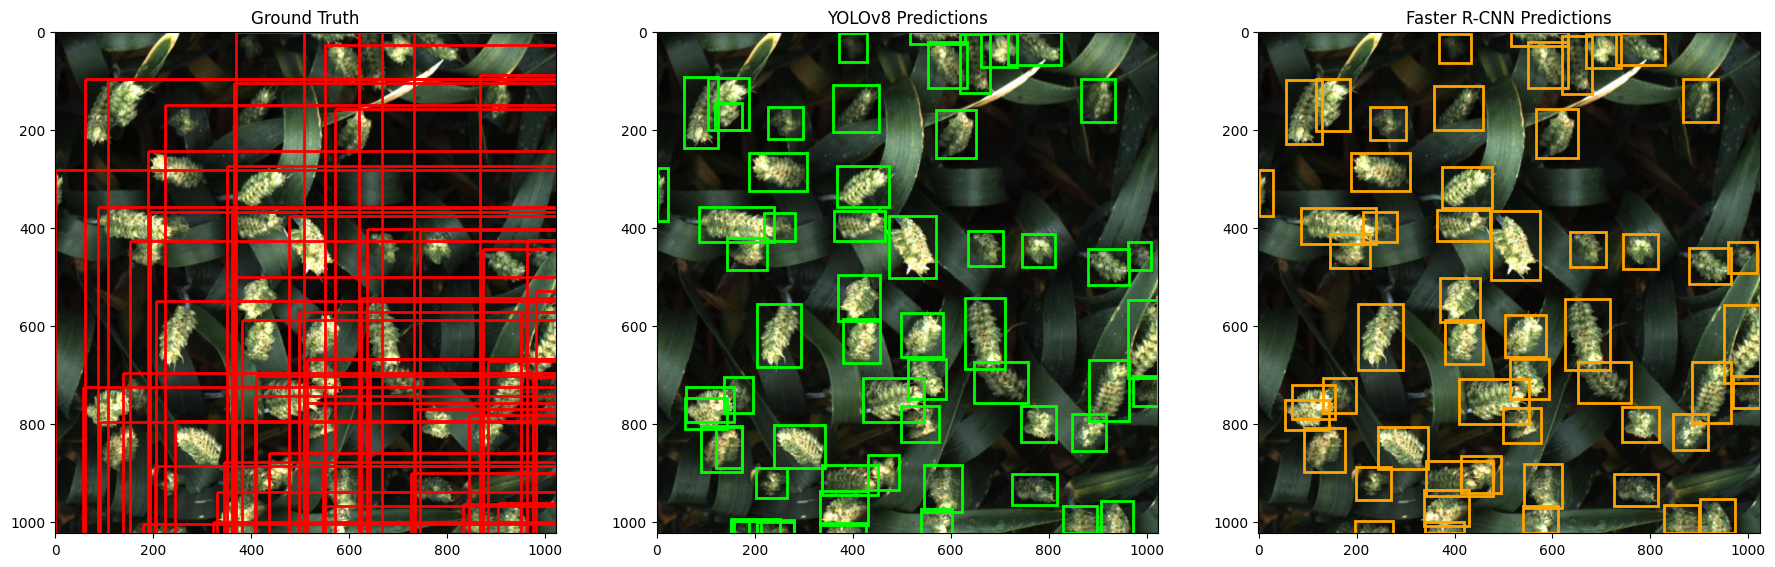

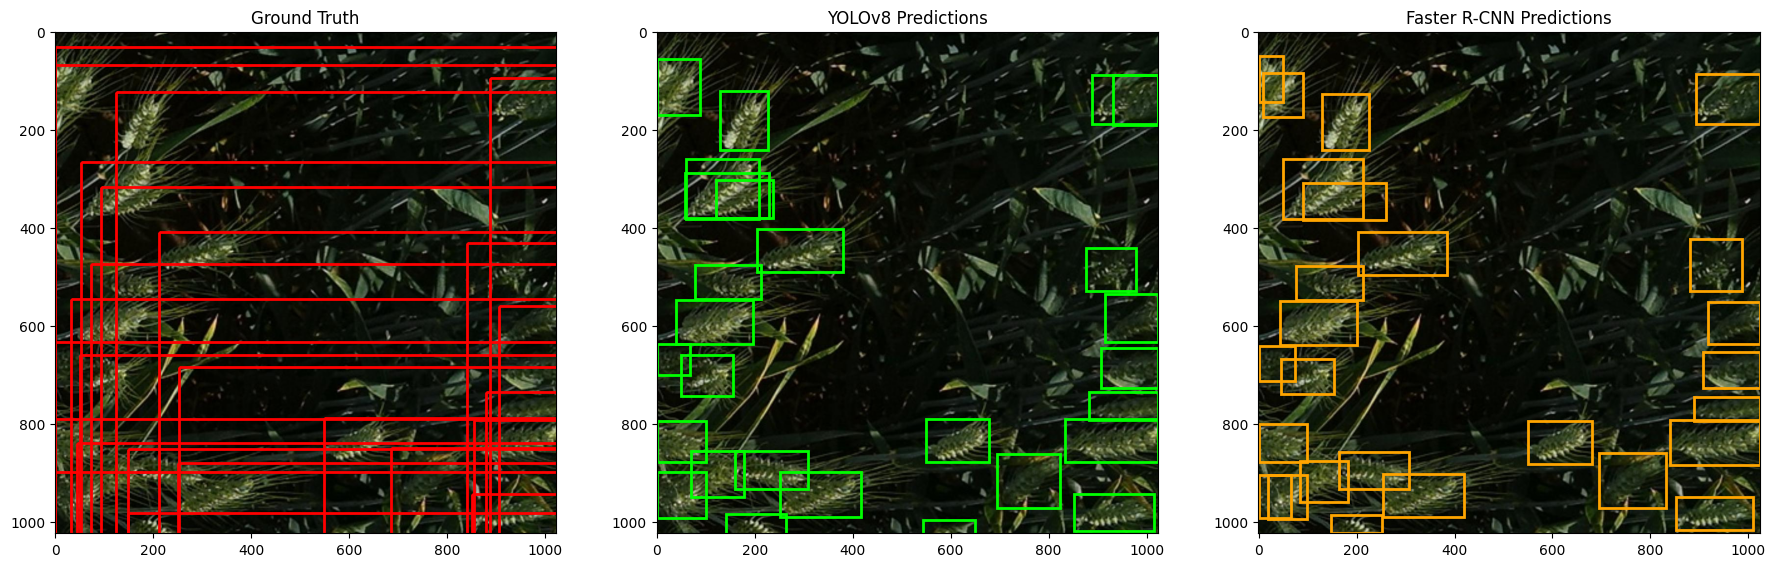

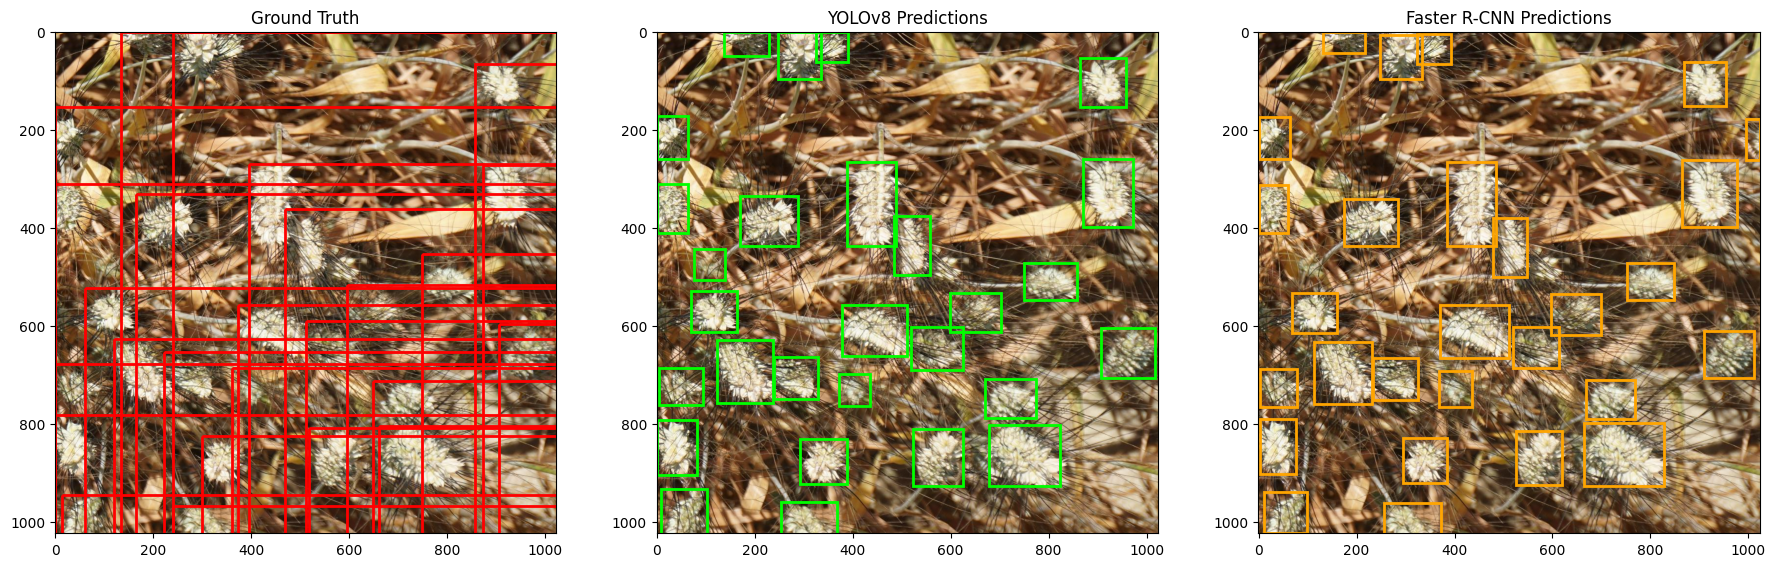

In [17]:
# -------------------------------
# Step 9: Visual Comparison (Ground Truth vs YOLO vs Faster R-CNN)
# -------------------------------
import random

def show_predictions_with_gt(img_ids, num_images=3, score_thresh=0.4):
    for img_id in random.sample(list(img_ids), num_images):
        img_path = os.path.join(train_dir, f"{img_id}.jpg")
        img = Image.open(img_path).convert("RGB")
        img_np = np.array(img)

        fig, axes = plt.subplots(1, 3, figsize=(22, 8))

        # --- Ground Truth ---
        axes[0].imshow(img_np)
        axes[0].set_title("Ground Truth")

        if "bbox" in df.columns:
            gt_boxes = df[df["image_id"] == img_id]["bbox"].tolist()
            gt_boxes = [eval(b) if isinstance(b, str) else b for b in gt_boxes]
        else:
            gt_subset = df[df["image_id"] == img_id][["x", "y", "width", "height"]].values
            gt_boxes = [list(b) for b in gt_subset]

        for x, y, w, h in gt_boxes:
            rect = patches.Rectangle((x, y), w, h,
                                     linewidth=2, edgecolor="red", facecolor="none")
            axes[0].add_patch(rect)

        # --- YOLOv8 Predictions ---
        yolo_preds = yolo_model(img_path, verbose=False)[0]
        axes[1].imshow(img_np)
        axes[1].set_title("YOLOv8 Predictions")
        for box in yolo_preds.boxes.xyxy.cpu().numpy():
            x1, y1, x2, y2 = box[:4]
            rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                     linewidth=2, edgecolor="lime", facecolor="none")
            axes[1].add_patch(rect)

        # --- Faster R-CNN Predictions ---
        frcnn.eval()
        with torch.no_grad():
            img_tensor = T.ToTensor()(img).unsqueeze(0).to(device)
            preds = frcnn(img_tensor)[0]
        axes[2].imshow(img_np)
        axes[2].set_title("Faster R-CNN Predictions")
        for box, score in zip(preds["boxes"].cpu(), preds["scores"].cpu()):
            if score >= score_thresh:
                x1, y1, x2, y2 = box
                rect = patches.Rectangle((x1, y1), x2-x1, y2-y1,
                                         linewidth=2, edgecolor="orange", facecolor="none")
                axes[2].add_patch(rect)

        plt.show()

# Show a few side-by-side results
show_predictions_with_gt(val_ids, num_images=3, score_thresh=0.5)
